In [ ]:
#Load needed packages
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import entropy
import argparse
import logging
from sklearn.metrics import roc_auc_score


logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S', level=logging.INFO)
logger = logging.getLogger('datagravity')


import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
#from ann_visualizer.visualize import ann_viz
# 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from IPython.display import display, Math, Latex


In [3]:
from anomaly_detection import AnomalyDetector

In [208]:
#Load data
data_path='/Users/jkchandalia/Downloads/eopktosm7ii6taabajbkyeiaai.csv'
label_path='/Users/jkchandalia/Downloads/zgnpf5sm7ai6taabajbkyeiaai.csv'
output_path='/Users/jkchandalia/Research/data_gravity/'
full_data = pd.read_csv('/Users/jkchandalia/Downloads/eopktosm7ii6taabajbkyeiaai.csv')
labels = pd.read_csv('/Users/jkchandalia/Downloads/zgnpf5sm7ai6taabajbkyeiaai.csv')

In [209]:
logger.info('Creating instance of class.')
ad_311 = AnomalyDetector(data_path, label_path, output_path)
logger.info('Reading in data.')
raw_data = pd.read_csv(ad_311.data_path)
labels = pd.read_csv(ad_311.labels_path)
logger.info('Prepping data.')
full_raw_data = ad_311.prep_311_data(raw_data, labels)



04/15/2019 01:12:57 Creating instance of class.
04/15/2019 01:12:57 Reading in data.
04/15/2019 01:13:07 Prepping data.


In [ ]:
logger.info('Creating training dataset.')
X_train, X_test, y_train = ad_311.make_train_test_data(full_raw_data, labels)

print(len(X_train))
logger.info('Training model.')
best_model = ad_311.train_model(X_train, y_train, cv=3)
print(best_model)
feature_importances = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)
predictions = ad_311.make_predictions(best_model, X_train)
print(predictions)
predictions.to_csv('~/Research/data_gravity/predictions.csv')
print(roc_auc_score(y_train, predictions))


In [214]:
df = full_raw_data
df['minutes'] = df.created_date_timestamp.dt.minute+df.hour*60
df['day'] = df.created_date_timestamp.dt.dayofweek
df.day

0          4
1          4
2          4
3          4
4          4
5          4
6          4
7          4
8          4
9          4
10         4
11         4
12         4
13         4
14         4
15         4
16         4
17         4
18         4
19         4
20         4
21         4
22         4
23         4
24         4
25         4
26         4
27         4
28         4
29         4
          ..
4401027    6
4401028    6
4401029    6
4401030    6
4401031    6
4401032    6
4401033    6
4401034    6
4401035    6
4401036    6
4401037    6
4401038    6
4401039    6
4401040    6
4401041    6
4401042    6
4401043    6
4401044    6
4401045    6
4401046    6
4401047    6
4401048    6
4401049    6
4401050    6
4401051    6
4401052    6
4401053    6
4401054    6
4401055    6
4401056    6
Name: day, Length: 4401057, dtype: int64

In [7]:
def expand_categorical_feature(df, raw_feature, cutoff=0.9, num_features=10):
    """Aggregate categorical data (including null/other) for df[column] with optional cutoffs."""
    df[raw_feature] = df[raw_feature].fillna('no_' + raw_feature)
    df_agg = df.groupby(['date', raw_feature]).agg({raw_feature: 'count'}).apply(list).apply(pd.Series)
    df_agg = df_agg.unstack()

    feature_sums = df_agg.sum(axis=0).sort_values(ascending=False)
    percentile90 = np.where(np.cumsum(feature_sums).values / sum(feature_sums) > cutoff)[0][0] + 1
    max_features = min(percentile90, num_features)
    cols = list(feature_sums[0:max_features][raw_feature].index)
    cols.append('no_' + raw_feature)

    #full_raw_data.borough[~full_raw_data.borough.isin(boroughs)]='other'
    updated_features = df[raw_feature]
    updated_features[~df[raw_feature].isin(cols)] ='other_' + raw_feature
    df[raw_feature] = updated_features
    
    df_feature = pd.get_dummies(df[raw_feature])
    df = pd.merge(df, df_feature, right_index=True, left_index=True)
    df = df.drop(raw_feature, axis=1)
        
    return df


In [11]:
raw_categorical_features = ['agency_name', 'borough', 'complaint_type', 'descriptor', 'location_type', 'day']
df_expand = df
for raw_feature in raw_categorical_features:
    logger.info('Expanding ' + raw_feature)
    df_expand = expand_categorical_feature(df_expand, raw_feature)
print(df.columns)

04/12/2019 12:38:58 Expanding agency_name
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
04/12/2019 12:39:03 Expanding borough
04/12/2019 12:39:08 Expanding complaint_type
04/12/2019 12:39:13 Expanding descriptor
04/12/2019 12:39:19 Expanding location_type
04/12/2019 12:39:24 Expanding day
/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index([                                      'created_date',
                                                 'latitude',
                                                'longitude',
                                             'minutes_open',
                                   'created_date_timestamp',
                                              'date_string',
                                                     'hour',
                                              'log_minutes',
                                                     'date',
                                                      'set',
                                                    'chaos',
                                                  'minutes',
                                  'Department of Buildings',
                   'Department of Environmental Protection',
                                    'Department of Finance',
                  'Department of Health and Mental Hygiene',
       'Department of Ho

In [141]:
df_pared = df.drop(['created_date','minutes_open','date_string','set','hour'],axis=1)

df_train = df_pared.dropna(subset=['chaos'])
df_test = df_pared.loc[df_pared.chaos.isnull(), :].reset_index(drop=True)
validation_timestamp = pd.Timestamp('2016-10-15T12')
#df_validation= df_train.loc[df_train.created_date_timestamp>validation_timestamp,:].reset_index(drop=True)
#df_train = df_train.loc[df_train.created_date_timestamp<=validation_timestamp,:]

y_train = df_train.chaos
X_train = df_train.fillna(0).drop(['chaos', 'date', 'created_date_timestamp'], axis=1)

#y_validation = df_validation.chaos
#X_validation = df_validation.fillna(0).drop(['chaos', 'created_date_timestamp'], axis=1)

y_test = df_test.chaos
X_test = df_test.fillna(0).drop(['chaos', 'date', 'created_date_timestamp'], axis=1)

X_autoencoder = X_train.loc[y_train==False,:]
#X_test = df_test.fillna(0)[feature_cols]
#y_train =df_train.chaos.tolist()

#print('Training data size   :', X_train.shape)
#print('Validation data size :', X_test.shape)



In [142]:
scaler = MinMaxScaler()
X_autoencoder_scaled = scaler.fit_transform(X_autoencoder)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

/Users/jkchandalia/Research/workspace/venv/vmain/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [143]:
X_autoencoder.columns

Index([                                          'latitude',
                                                'longitude',
                                              'log_minutes',
                                                  'minutes',
                                  'Department of Buildings',
                   'Department of Environmental Protection',
                                    'Department of Finance',
                  'Department of Health and Mental Hygiene',
       'Department of Housing Preservation and Development',
                       'Department of Parks and Recreation',
                                 'Department of Sanitation',
                             'Department of Transportation',
                          'New York City Police Department',
        'Operations Unit - Department of Homeless Services',
                                           'no_agency_name',
                                        'other_agency_name',
                        

In [86]:
# No of Neurons in each Layer [9,6,3,2,3,6,9]
input_dim = X_autoencoder.shape[1]
encoding_dim = 48

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu")(input_layer) #,activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(40), activation="relu")(encoder)
encoder = Dense(int(32), activation="relu")(encoder)
encoder = Dense(int(24), activation="relu")(encoder)
encoder = Dense(int(16), activation="relu")(encoder)
decoder = Dense(int(24), activation='relu')(encoder)
decoder = Dense(int(32), activation='relu')(decoder)
decoder = Dense(int(40), activation='relu')(decoder)
decoder = Dense(int(48), activation='relu')(decoder)
decoder = Dense(int(encoding_dim), activation='relu')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 60)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 48)                2928      
_________________________________________________________________
dense_42 (Dense)             (None, 40)                1960      
_________________________________________________________________
dense_43 (Dense)             (None, 32)                1312      
_________________________________________________________________
dense_44 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_45 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_46 (Dense)             (None, 24)                408       
__________

In [147]:
nb_epoch = 250
batch_size = 50
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#model.compile(loss='mean_squared_error', optimizer=sgd)

autoencoder.compile(optimizer=adam, loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(X_autoencoder_scaled, X_autoencoder_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))



df_history = pd.DataFrame(history.history)


Time to run the model: 8833.208351 Sec.


In [150]:
autoencoder.save('/Users/jkchandalia/Research/workspace/anomalydetection/autoencoder_correctdata')


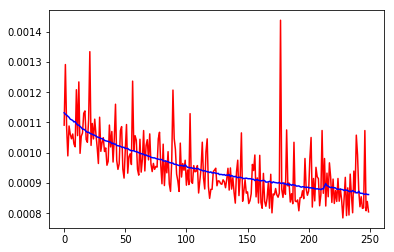

In [149]:
plt.plot(df_history.val_loss, 'r-')
plt.plot(df_history.loss, 'b-')


In [109]:
#Load partly trained model
from keras.models import load_model
model = load_model('/Users/jkchandalia/Research/workspace/anomalydetection/autoencoder_bigger')

#Continue training
#model.fit(second_training, second_classes, batch_size=32, nb_epoch=20)


nb_epoch = 100
batch_size = 50
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#model.compile(loss='mean_squared_error', optimizer=sgd)

#autoencoder.compile(optimizer=adam, loss='mse' )

t_ini = datetime.datetime.now()
history = model.fit(X_train_scaled, X_train_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))



df_history = pd.DataFrame(history.history)


Time to run the model: 4672.174758 Sec.


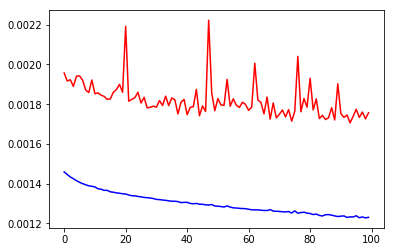

In [110]:
plt.plot(df_history.val_loss, 'r-')
plt.plot(df_history.loss, 'b-')


In [113]:
model.save('/Users/jkchandalia/Research/workspace/anomalydetection/autoencoder_bigger2')


In [152]:
df_history

,val_loss,loss
0,0.001091,0.001132
1,0.001291,0.001127
2,0.001085,0.001124
3,0.000989,0.001120
4,0.001088,0.001117
5,0.001061,0.001111
6,0.001046,0.001109
7,0.001062,0.001107
8,0.001029,0.001102
9,0.001019,0.001103


In [151]:
def train_validation_loss(df_history):
    
    trace = []
    
    for label, loss in zip(['Train', 'Validation'], ['loss', 'val_loss']):
        trace0 = {'type' : 'scatter', 
                  'x'    : df_history.index.tolist(),
                  'y'    : df_history[loss].tolist(),
                  'name' : label,
                  'mode' : 'lines'
                  }
        trace.append(trace0)
    data = Data(trace)
    
    layout = {'title' : 'Model train-vs-validation loss', 'titlefont':{'size' : 30},
              'xaxis' : {'title':  '<b> Epochs', 'titlefont':{ 'size' : 25}},
              'yaxis' : {'title':  '<b> Loss', 'titlefont':{ 'size' : 25}},
              }
    fig = Figure(data = data, layout = layout)
    
    return pyo.iplot(fig)
df_history

,val_loss,loss
0,0.001091,0.001132
1,0.001291,0.001127
2,0.001085,0.001124
3,0.000989,0.001120
4,0.001088,0.001117
5,0.001061,0.001111
6,0.001046,0.001109
7,0.001062,0.001107
8,0.001029,0.001102
9,0.001019,0.001103


In [239]:
predictions = model.predict(X_test_scaled)

mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_test}, index=y_test.index)
df_error.describe()

X_scaled = pd.concat([X_train_scaled, X_test_scaled]).reset_index(drop=True)

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [251]:
X_scaled = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
X_scaled = pd.DataFrame(X_scaled).fillna(0)

In [247]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(X_scaled.shape)



(2177051, 60)
(2224006, 60)
(4401057, 60)


In [261]:
predictions = autoencoder.predict(X_scaled)

mse = np.mean(np.power(X_scaled - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse})
df_error.describe()

,reconstruction_error
count,4.401057e+06
mean,3.401911e-03
std,1.797700e-02
min,2.357876e-05
25%,1.207684e-04
50%,2.231395e-04
75%,4.979003e-04
max,5.648662e-01


In [260]:
predictions.shape
X_scaled.shape

(4401057, 60)

In [157]:
print(predictions)
print(X_train_scaled)
len(df_error.Label)

[[ 1.         -0.00326676  0.8145293  ...  0.9852088   0.00527329
  -0.00662663]
 [ 1.         -0.00748903  0.8210425  ...  0.98521715  0.00537223
  -0.00714326]
 [ 1.         -0.00322313  0.8196964  ...  0.9852456   0.00502892
  -0.00880004]
 ...
 [ 0.99996996  0.07726217  0.82235736 ...  0.98463917  0.01593002
   0.02210912]
 [ 0.99996996  0.07726217  0.82235736 ...  0.98463917  0.01593002
   0.02210912]
 [ 1.         -0.00663958  0.661178   ...  0.9850386   0.01256376
  -0.02502598]]
[[0.99389654 0.00522895 0.82151807 ... 1.         0.         0.        ]
 [0.99263441 0.00410499 0.84041962 ... 1.         0.         0.        ]
 [0.9948446  0.00504086 0.81928151 ... 1.         0.         0.        ]
 ...
 [0.99348988 0.0039713  0.86966815 ... 1.         0.         0.        ]
 [0.99348988 0.0039713  0.86966815 ... 1.         0.         0.        ]
 [0.99459167 0.00542712 0.66651214 ... 1.         0.         0.        ]]


2177051

In [134]:
print(X_train.columns)

Index([                                          'latitude',
                                                'longitude',
                                              'log_minutes',
                                                  'minutes',
                                  'Department of Buildings',
                   'Department of Environmental Protection',
                                    'Department of Finance',
                  'Department of Health and Mental Hygiene',
       'Department of Housing Preservation and Development',
                       'Department of Parks and Recreation',
                                 'Department of Sanitation',
                             'Department of Transportation',
                          'New York City Police Department',
        'Operations Unit - Department of Homeless Services',
                                           'no_agency_name',
                                        'other_agency_name',
                        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


TypeError: must be str, not int

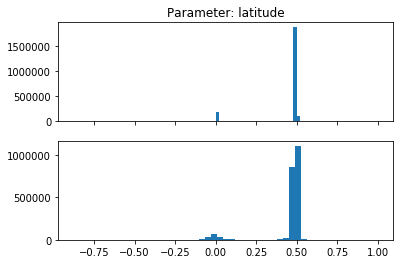

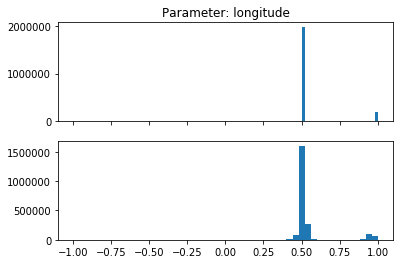

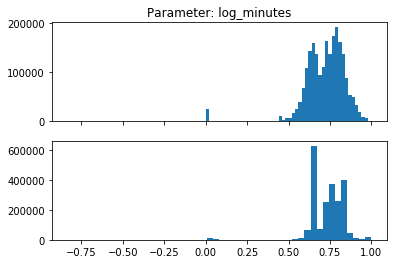

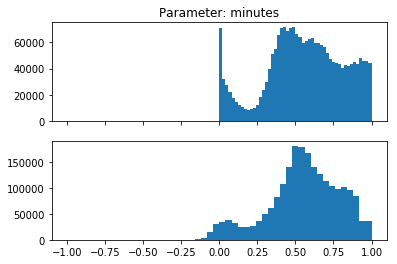

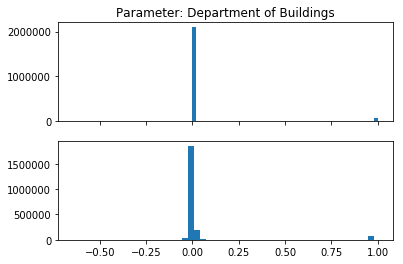

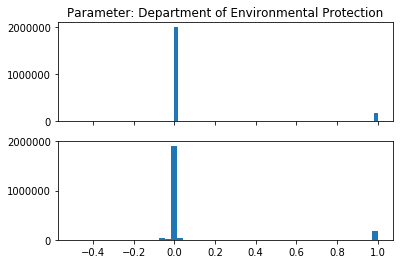

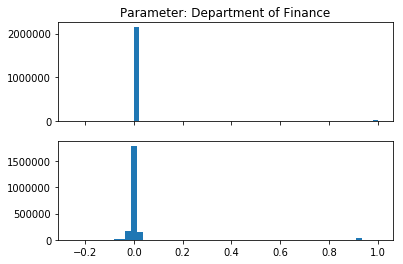

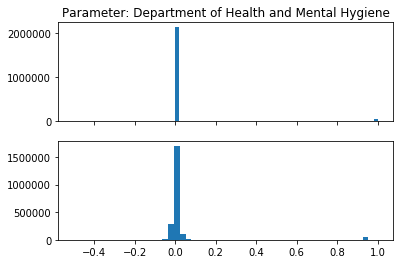

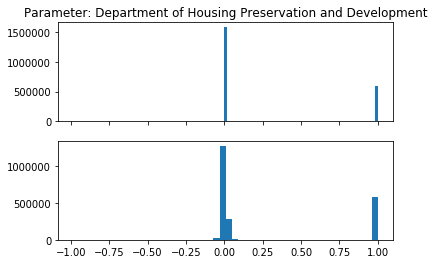

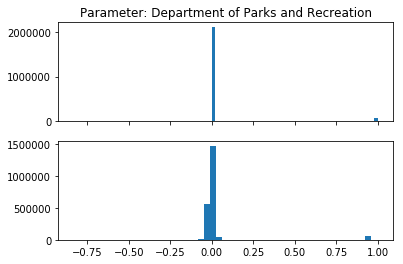

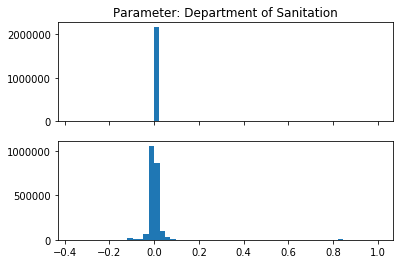

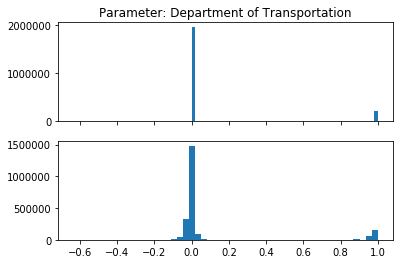

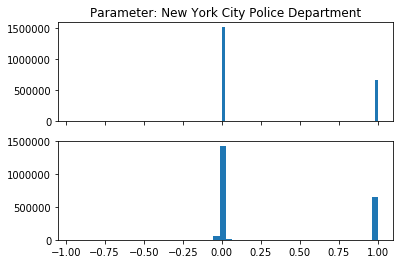

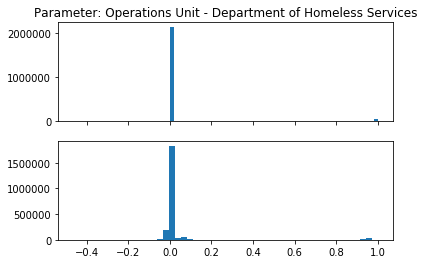

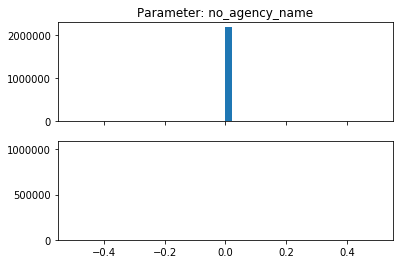

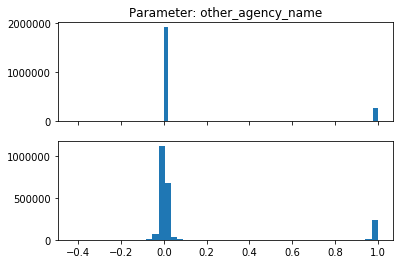

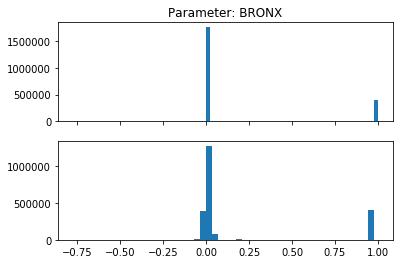

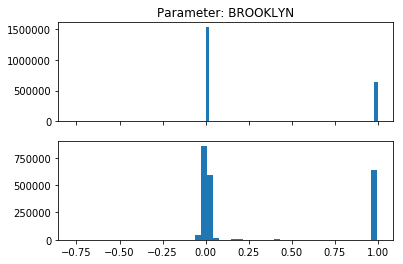

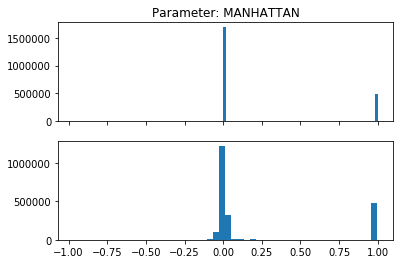

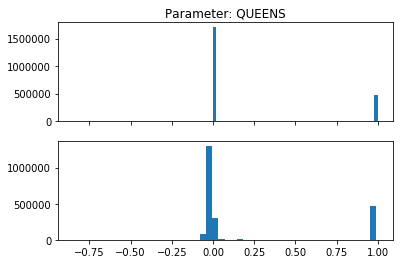

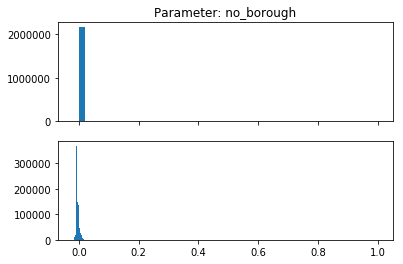

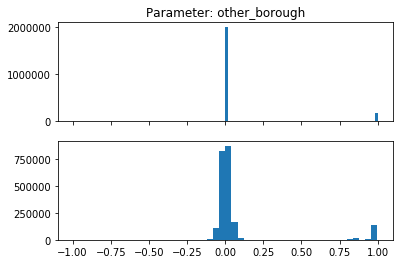

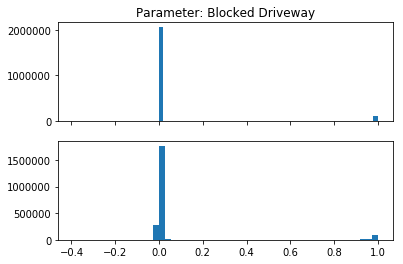

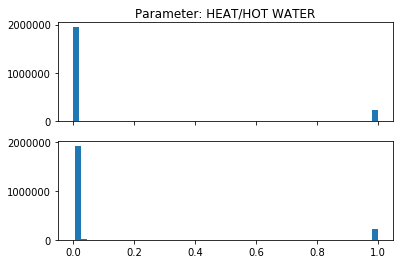

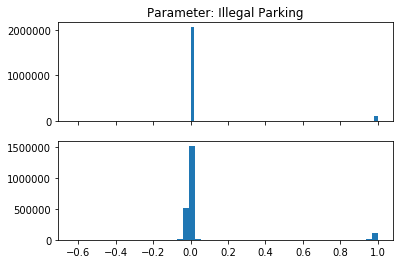

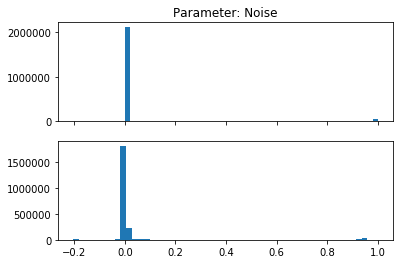

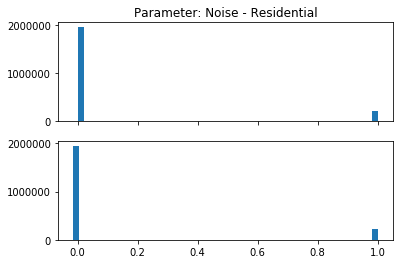

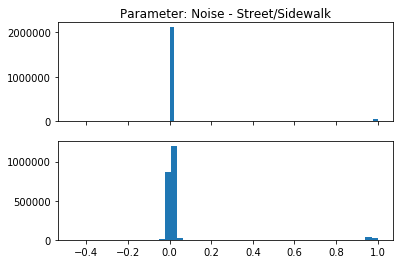

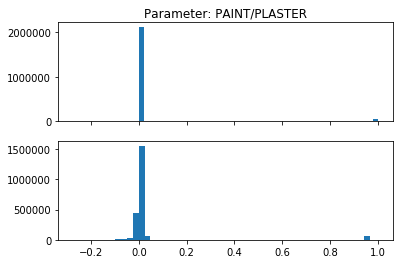

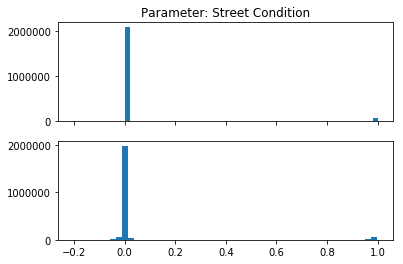

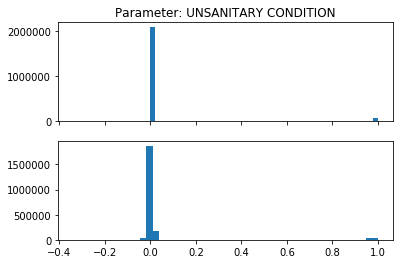

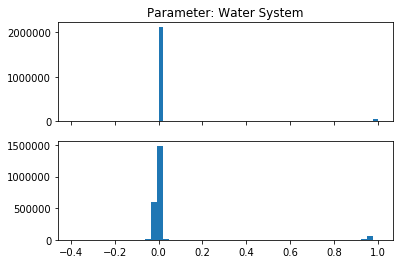

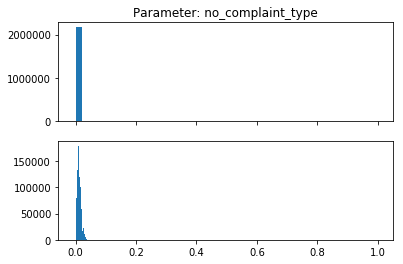

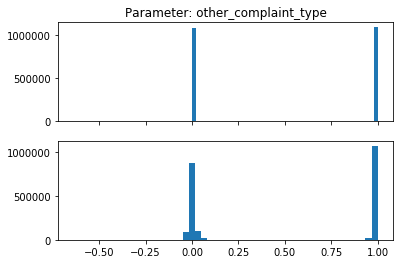

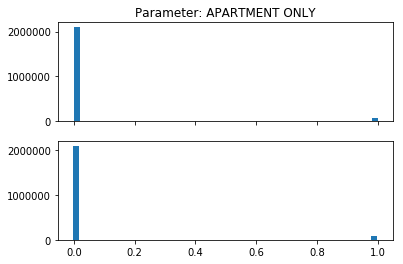

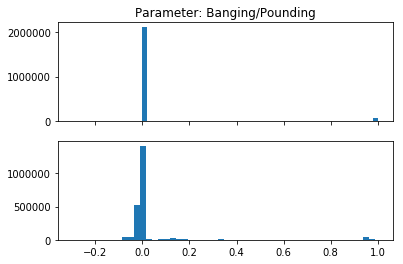

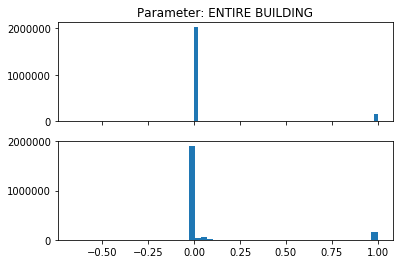

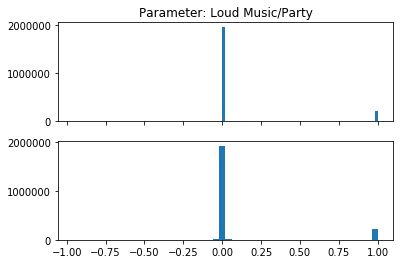

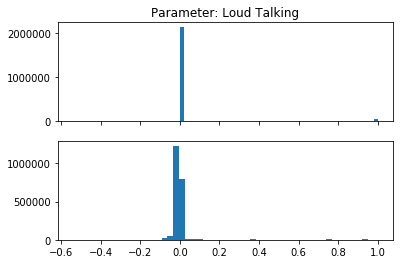

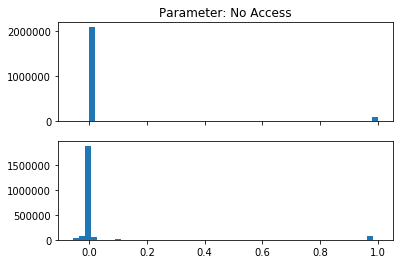

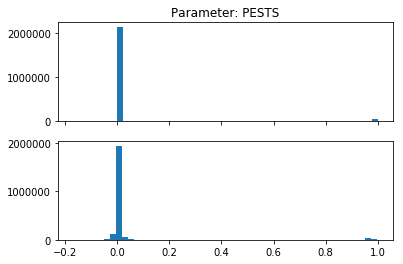

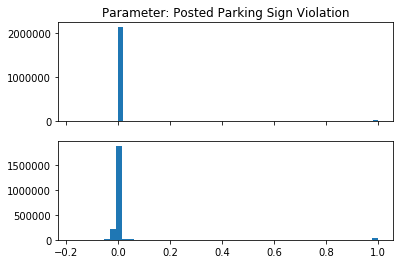

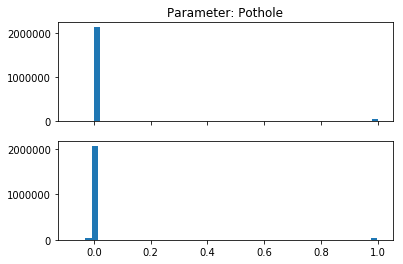

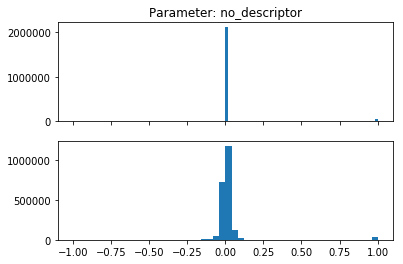

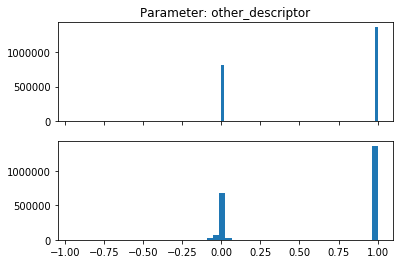

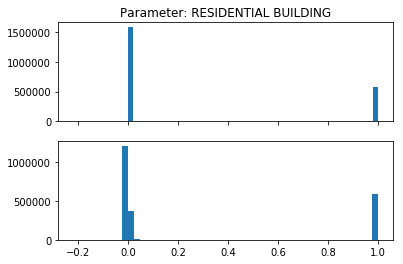

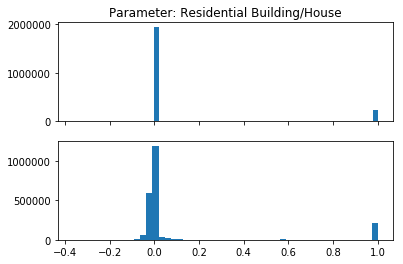

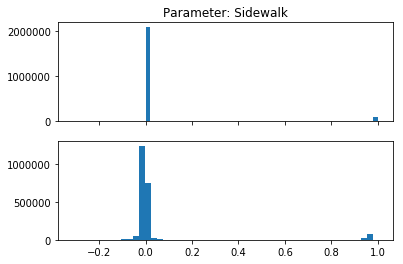

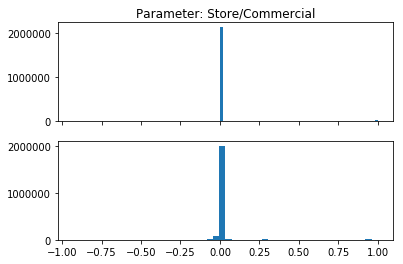

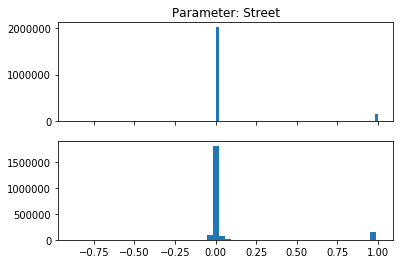

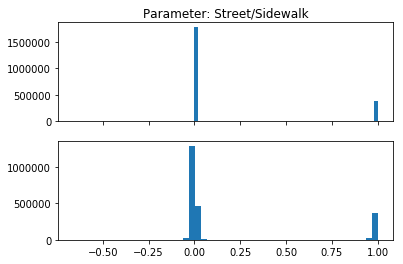

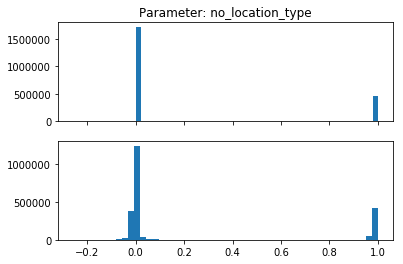

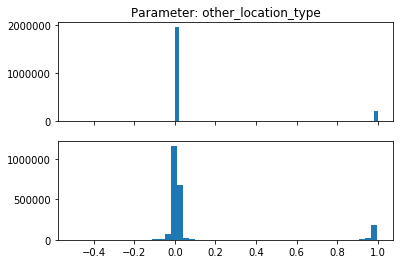

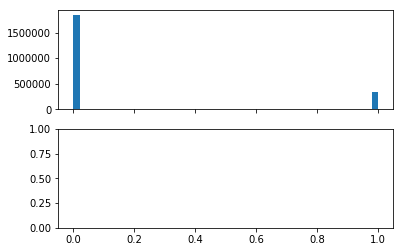

In [140]:
#Creates two subplots and unpacks the output array immediately
for i in range(0,len(X_train.columns)):
    print(i)
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.hist(X_train_scaled[:,i],50)
    ax1.set_title('Parameter: '+X_train.columns[i])
    ax2.hist(predictions[:,i],50)
    f.savefig('/Users/jkchandalia/Research/data_gravity/compare_autoencoding_'+X_train.columns[i].replace('/','_').replace(' ','_')+'.png')

In [138]:
f.close()

AttributeError: 'Figure' object has no attribute 'close'

In [36]:
sum(df_error.Label)
df_train.columns

Index([                                          'latitude',
                                                'longitude',
                                   'created_date_timestamp',
                                              'log_minutes',
                                                    'chaos',
                                                  'minutes',
                                  'Department of Buildings',
                   'Department of Environmental Protection',
                                    'Department of Finance',
                  'Department of Health and Mental Hygiene',
       'Department of Housing Preservation and Development',
                       'Department of Parks and Recreation',
                                 'Department of Sanitation',
                             'Department of Transportation',
                          'New York City Police Department',
        'Operations Unit - Department of Homeless Services',
                        

In [115]:
predictions = model.predict(X_train_scaled)

mse = np.mean(np.power(X_train_scaled - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_train.astype(int)})
df_error.describe()

print(predictions)
print(X_train_scaled)

X_train.columns

[[ 0.47982708  0.5213366   0.80414474 ...  0.98505193 -0.01020623
   0.01234695]
 [ 0.4798892   0.5213641   0.80425864 ...  0.98505694 -0.01024032
   0.01217067]
 [ 0.47954127  0.5228327   0.807602   ...  0.9851081  -0.01571049
   0.01219069]
 ...
 [ 0.48444188  0.5530317   0.8454598  ...  0.9853983  -0.01529491
   0.00409279]
 [ 0.48444188  0.5530317   0.8454598  ...  0.9853983  -0.01529491
   0.00409279]
 [ 0.48709628  0.5079393   0.6511436  ...  0.9849475  -0.02292899
   0.00227773]]
[[0.49749615 0.50234119 0.82151807 ... 1.         0.         0.        ]
 [0.49686439 0.5017789  0.84041962 ... 1.         0.         0.        ]
 [0.49797071 0.50224709 0.81928151 ... 1.         0.         0.        ]
 ...
 [0.4972926  0.50171202 0.86966815 ... 1.         0.         0.        ]
 [0.4972926  0.50171202 0.86966815 ... 1.         0.         0.        ]
 [0.4978441  0.50244033 0.66651214 ... 1.         0.         0.        ]]


Index([                                          'latitude',
                                                'longitude',
                                              'log_minutes',
                                                  'minutes',
                                  'Department of Buildings',
                   'Department of Environmental Protection',
                                    'Department of Finance',
                  'Department of Health and Mental Hygiene',
       'Department of Housing Preservation and Development',
                       'Department of Parks and Recreation',
                                 'Department of Sanitation',
                             'Department of Transportation',
                          'New York City Police Department',
        'Operations Unit - Department of Homeless Services',
                                           'no_agency_name',
                                        'other_agency_name',
                        

In [ ]:
sum(df_error.Label)/len(df_error)


In [ ]:
#plt.plot(df_history.val_loss, 'r-')
#plt.plot(df_history.loss, 'b-')
plt.hist(df_history.loss)
plt.figure()
plt.hist(df_history.val_loss)
print(min(df_history.loss))
print(max(df_history.loss))

In [263]:
len(df_train.date)
print(len(df_error))
df_error['date']=df.date

4401057


In [262]:
df.date

0          2016-01-01
1          2016-01-01
2          2016-01-01
3          2016-01-01
4          2016-01-01
5          2016-01-01
6          2016-01-01
7          2016-01-01
8          2016-01-01
9          2016-01-01
10         2016-01-01
11         2016-01-01
12         2016-01-01
13         2016-01-01
14         2016-01-01
15         2016-01-01
16         2016-01-01
17         2016-01-01
18         2016-01-01
19         2016-01-01
20         2016-01-01
21         2016-01-01
22         2016-01-01
23         2016-01-01
24         2016-01-01
25         2016-01-01
26         2016-01-01
27         2016-01-01
28         2016-01-01
29         2016-01-01
              ...    
4401027    2017-12-31
4401028    2017-12-31
4401029    2017-12-31
4401030    2017-12-31
4401031    2017-12-31
4401032    2017-12-31
4401033    2017-12-31
4401034    2017-12-31
4401035    2017-12-31
4401036    2017-12-31
4401037    2017-12-31
4401038    2017-12-31
4401039    2017-12-31
4401040    2017-12-31
4401041   

In [266]:
df_error_date=df_error.groupby(['date']).agg({'reconstruction_error':['max','min','mean','median','std']}).apply(list).apply(pd.Series)
df_error_date
#end_labels = labels[labels.set=='train'].chaos.astype(int).values
#df_error_date['labels'] = end_labels
out = pd.DataFrame({'date': df_error_date.index, 'scores': df_error_date.reconstruction_error['std']})

In [269]:
out = out.reset_index(drop=True)
scores = out
scores.to_csv('/Users/jkchandalia/Research/data_gravity/scores_DL.csv', index=False)

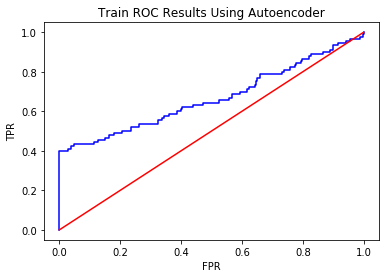

In [282]:
import sklearn
roc_metrics = sklearn.metrics.roc_curve(labels.chaos[0:365].astype(int), out.scores[0:365])
roc_metrics
plt.plot(roc_metrics[0], roc_metrics[1],'b')
plt.plot([0,1],[0,1],'r')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Train ROC Results Using Autoencoder')
plt.savefig('/Users/jkchandalia/Research/data_gravity/autoencoder.png')

In [283]:
df_error_date.reconstruction_error['std'].values
y_train = labels.chaos[~labels.chaos.isnull()]
preds = df_error_date.reconstruction_error['std'][0:len(y_train)].values
roc_auc_score(y_train.astype(int), preds.tolist())
#preds.tolist()

#labels
#y_train.astype(int)
#df_error_date

0.6677575757575758

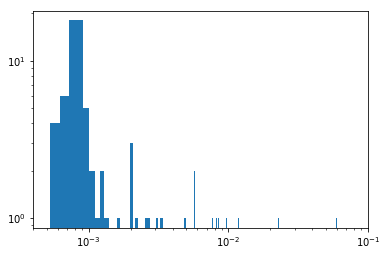

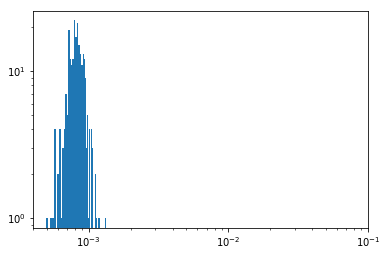

In [174]:
df_error_date.reconstruction_error['mean'][df_error_date.labels==1]
plt.hist(df_error_date.reconstruction_error['mean'][df_error_date.labels==1],1000)
plt.xlim([0.0004, 0.1])
plt.yscale('log')
plt.xscale('log')
plt.figure()
plt.hist(df_error_date.reconstruction_error['mean'][df_error_date.labels==0],50)
plt.xlim([0.0004, 0.1])
plt.yscale('log')
plt.xscale('log')


(array([  9.,   7.,  26.,  36.,  65.,  72.,  67.,  73.,  93.,  90.,  80.,
        123.,  99., 121., 140., 135., 159., 120., 133., 133., 138., 119.,
         81.,  78.,  73.,  87.,  97., 104.,  57.,  67.,  73.,  89.,  67.,
         48.,  55.,  39.,  28.,  31.,  21.,  15.,  13.,  14.,  12.,   9.,
         14.,   7.,   6.,   4.,  17.,  29.,  27.,  46.,  24.,  11.,  24.,
         15.,  12.,  13.,  11.,   7.,   8.,   4.,   8.,  56.,  44., 185.,
        127.,   4.,  58.,  23.,  56.,  12.,   3.,  16.,   6.,   4.,   0.,
          0.,   3.,   1.,  64.,  37.,  31.,  50.,  60.,  15.,  20.,   6.,
         14.,  11.,   1.,   1.,   5.,   3.,   3.,   5.,   4.,   5.,   2.,
          1.]),
 array([-9.94631364, -9.86504275, -9.78377187, -9.70250098, -9.6212301 ,
        -9.53995922, -9.45868833, -9.37741745, -9.29614657, -9.21487568,
        -9.1336048 , -9.05233391, -8.97106303, -8.88979215, -8.80852126,
        -8.72725038, -8.64597949, -8.56470861, -8.48343773, -8.40216684,
        -8.32089596, -8.23

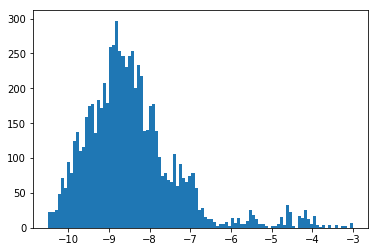

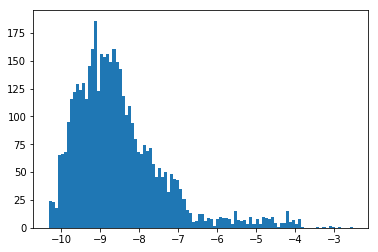

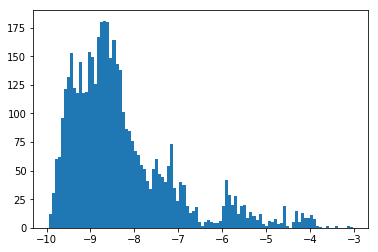

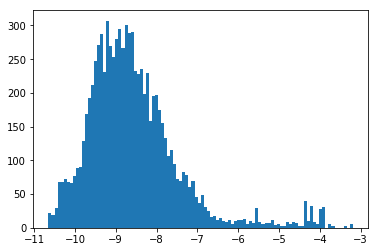

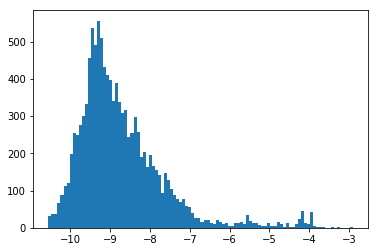

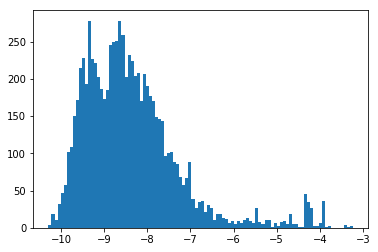

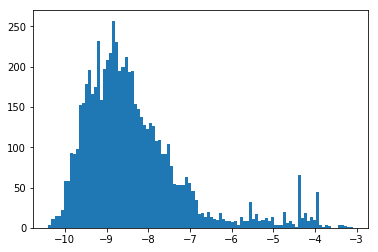

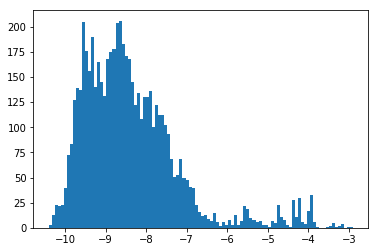

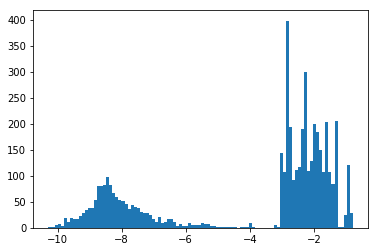

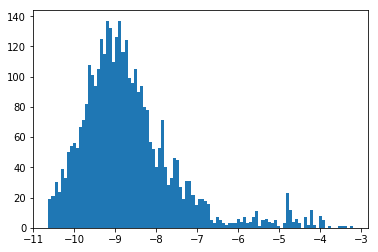

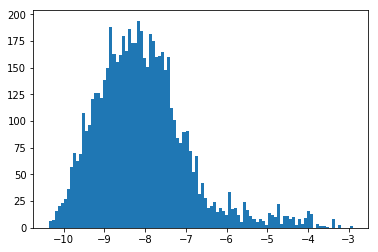

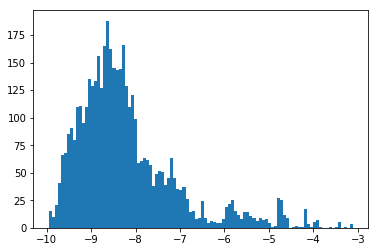

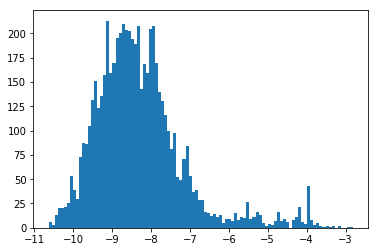

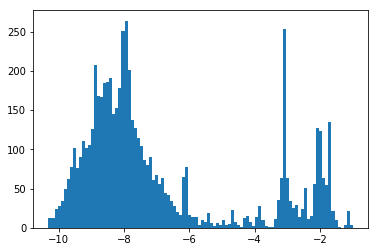

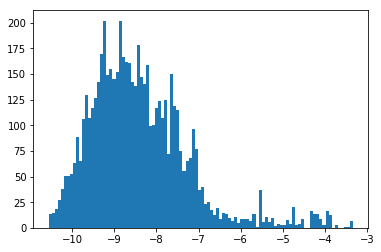

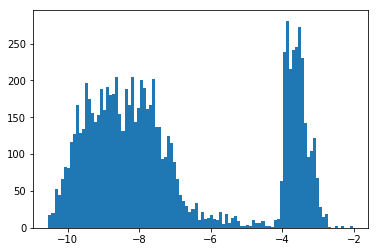

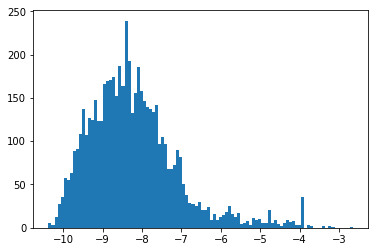

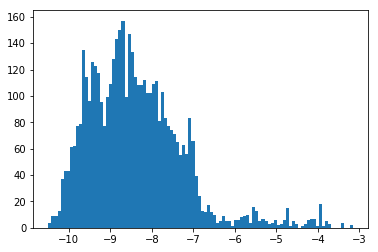

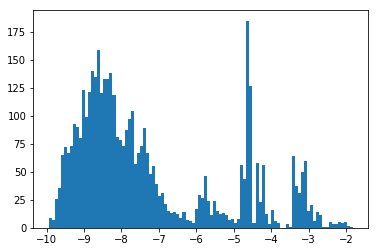

In [200]:
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-01']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-02']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-03']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-04']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-05']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-06']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-07']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-08']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-09']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-18']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-28']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-01-31']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-02-01']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-02-03']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-02-09']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-02-16']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-02-25']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-02-26']['reconstruction_error']),100)
plt.figure()
plt.hist(np.log(df_error[df_error['date']=='2016-02-28']['reconstruction_error']),100)


In [211]:
df[df.date=='2016-01-09'].to_csv('/Users/jkchandalia/Research/data_gravity/caught_by_auto_20160109.csv')
df[df.date=='2016-02-03'].to_csv('/Users/jkchandalia/Research/data_gravity/caught_by_auto_20160203.csv')
df[df.date=='2016-02-16'].to_csv('/Users/jkchandalia/Research/data_gravity/caught_by_auto_20160216.csv')
df[df.date=='2016-02-28'].to_csv('/Users/jkchandalia/Research/data_gravity/caught_by_auto_20160228.csv')


37


90

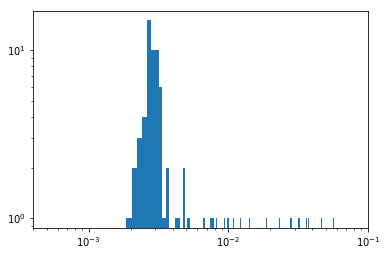

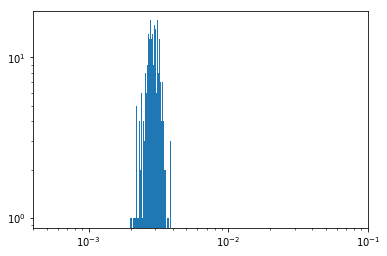

In [201]:
df_error_date.reconstruction_error['std'][df_error_date.labels==1]
plt.hist(df_error_date.reconstruction_error['std'][df_error_date.labels==1],500)
plt.xlim([0.0004, 0.1])
plt.yscale('log')
plt.xscale('log')
plt.figure()
plt.hist(df_error_date.reconstruction_error['std'][df_error_date.labels==0],50)
plt.xlim([0.0004, 0.1])
plt.yscale('log')
plt.xscale('log')
print(sum(df_error_date.reconstruction_error['std']>.004))
len(df_error_date[df_error_date.labels==1])

23


365

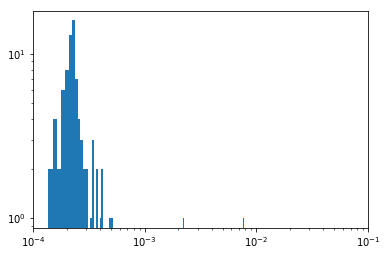

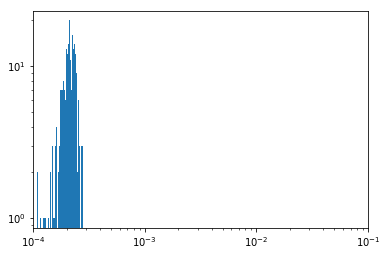

In [186]:
df_error_date.reconstruction_error['median'][df_error_date.labels==1]
plt.hist(df_error_date.reconstruction_error['median'][df_error_date.labels==1],5000)
plt.xlim([0.0001, 0.1])
plt.yscale('log')
plt.xscale('log')
plt.figure()
plt.hist(df_error_date.reconstruction_error['median'][df_error_date.labels==0],50)
plt.xlim([0.0001, 0.1])
plt.yscale('log')
plt.xscale('log')

print(sum(df_error_date.reconstruction_error['median']>.0003))
len(df_error_date)

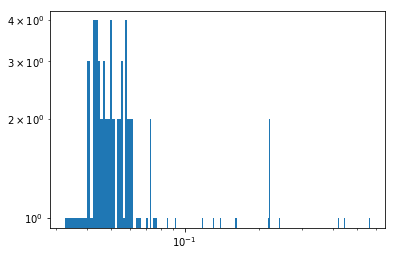

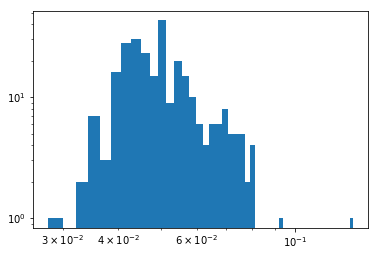

In [203]:
df_error_date.reconstruction_error['max'][df_error_date.labels==1]
plt.hist(df_error_date.reconstruction_error['max'][df_error_date.labels==1],500)
#plt.xlim([0.0004, 0.1])
plt.yscale('log')
plt.xscale('log')
plt.figure()
plt.hist(df_error_date.reconstruction_error['max'][df_error_date.labels==0],50)
#plt.xlim([0.0004, 0.1])
plt.yscale('log')
plt.xscale('log')


In [122]:
df_error_date.reconstruction_error

,max,min,mean,median,std
date,,,,,
2016-01-01,0.042366,0.000072,0.000799,0.000217,0.002620
2016-01-02,0.053123,0.000064,0.000780,0.000213,0.002671
2016-01-03,0.044181,0.000088,0.000965,0.000243,0.002720
2016-01-04,0.039239,0.000070,0.000798,0.000211,0.002812
2016-01-05,0.052721,0.000073,0.000642,0.000187,0.002381
2016-01-06,0.035567,0.000054,0.000841,0.000230,0.002806
2016-01-07,0.049563,0.000068,0.001036,0.000231,0.003227
2016-01-08,0.063192,0.000072,0.001004,0.000234,0.003374
2016-01-09,0.108155,0.000066,0.020113,0.023194,0.017187


In [ ]:
#What are some things that are needed to do effective deep learning model training?
#saving checkpoints
# moving saved checkpoints from cloud machine to reliable storage (local or cloud)
#hyperparameter optimization
#Setting up a gpu environment
#write out parameters in some sort of sensible way (yml)?


(0.02, 0.18)

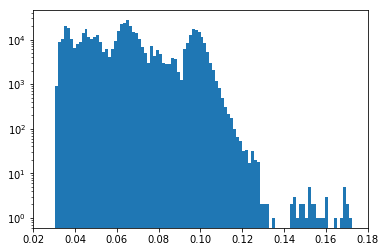

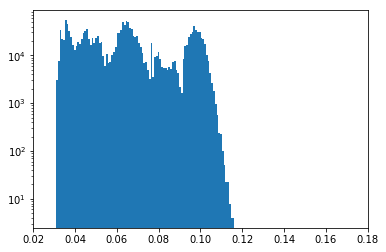

In [53]:
df_error.groupby(['Label']).agg({'reconstruction_error':'min'}).apply(list).apply(pd.Series)
plt.hist(df_error.reconstruction_error[df_error.Label==1],100)
plt.yscale('log')
plt.xlim([0.02,0.18])
plt.figure()
plt.hist(df_error.reconstruction_error[df_error.Label==0],100)
plt.yscale('log')
plt.xlim([0.02,0.18])


In [ ]:
logger.info('Creating training dataset.')
X_train, X_test, y_train = ad_311.make_train_test_data(full_raw_data, labels)

print(len(X_train))
logger.info('Training model.')
best_model = ad_311.train_model(X_train, y_train, cv=3)
print(best_model)
feature_importances = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)
predictions = ad_311.make_predictions(best_model, X_train)
print(predictions)
predictions.to_csv('~/Research/data_gravity/predictions.csv')
print(roc_auc_score(y_train, predictions))



In [ ]:
df_features

df_test = df_features.loc[df_features.chaos.isnull(), :].reset_index(drop=True)
df_test

df_test = df_features.loc[df_features.chaos.isnull(), :].reset_index(drop=True)
X_train = df_train.fillna(0)[feature_cols]
X_test = df_test.fillna(0)[feature_cols]
y_train =df_train.chaos.tolist()


In [ ]:
X = pd.concat([X_train, X_test]).reset_index(drop=True)

In [ ]:
#plt.plot(results)
print(len(X_train))
logger.info('Training model.')
best_model = ad_311.train_model(X_train, y_train, cv=3)
print(best_model)
feature_importances = pd.DataFrame(best_model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)
predictions = ad_311.make_predictions(best_model, X_train)
print(predictions)
predictions.to_csv('~/Research/data_gravity/predictions.csv')
print(roc_auc_score(y_train, predictions))


In [ ]:
X_test

In [ ]:
base_distribution = (df_test.mean(axis=0))[1:]+.0000001
base_distribution.values
#entropy(df_agg.loc[0,:], base_distribution)
#example_dist = df_agency.fillna(0).iloc[1,:].values
#entropy(example_dist.values, base_distribution)

def calculate_entropy(example_dist, base_dist=base_distribution):
    return entropy(example_dist, base_distribution)

out[out.date=='2017-08-18']
example_dist=df_agency.loc['2017-08-18',:].values
calculate_entropy(example_dist)
df_agency.loc['2017-08-18',:]


In [ ]:
#Deal with duplicate rows
def make_duplicate_ratio(df):
    df_dedup = df.drop_duplicates()
    df_dedup = df_dedup.groupby(['date']).agg({'date':'count'}).apply(list).apply(pd.Series)
    df_dup = df.groupby(['date']).agg({'date':'count'}).apply(list).apply(pd.Series)
    df_out = df_dup
    df_out['duplicate_ratio'] = list(df_dup['date'].values/df_dedup['date'])
    df_out.drop('date',axis=1,inplace=True)
    return df_out



In [ ]:
def get_dropped_rows_metric(df, hour_bin_size=6):
    print(df.columns)
    df['hour_bins'] = np.floor(df.hour/hour_bin_size)
    df_agg = df.groupby(['date', 'hour_bins']).agg({'hour_bins':'count'}).apply(list).apply(pd.Series)
    df_agg = df_agg.unstack()
    df_agg =    df_agg['hour_bins']
    df_agg = df_agg.div(df_agg.sum(axis=1), axis=0)
    
    return df_agg

#df_dropped['labels'] = list(labels.chaos)

In [ ]:
def get_weekday(df):
    out = pd.to_datetime(df.date).dt.dayofweek
    out.index=df.date
    out=pd.DataFrame((out<5).astype(int))
    out.columns=['weekday']
    return out



In [ ]:
#Summarize the numerical data (lat, long, log(minutes_open))
def summarize_numerical_feature(df, column):
    df_num = df.fillna(0).groupby(['date']).agg({column:'mean'}).apply(list).apply(pd.Series)
    df_num = pd.DataFrame(df_num[column])
    return df_num


In [ ]:
#Aggregate features
df_count = out.groupby(['date','chaos']).agg({'date':'count'}).apply(list).apply(pd.Series)
df_count.columns=['count']
df_count = df_count.reset_index()
df_agency = agg_feature(out,'agency_name')
df_borough = agg_feature(out,'borough')
df_complaint = agg_feature(out,'complaint_type')
df_descriptor = agg_feature(out,'descriptor')
df_location = agg_feature(out,'location_type')
df_dayofweek = get_weekday(labels)

df_dup = make_duplicate_ratio(out)

df_dropped = dropped_rows_metric(out)

df_long=summarize_numerical_feature(out, 'longitude')
df_lat=summarize_numerical_feature(out, 'latitude')
df_log_min=summarize_numerical_feature(out, 'log_minutes')

df_full=pd.merge(df_count, df_agency, on ='date')
df_full=pd.merge(df_full, df_borough, on ='date')
df_full=pd.merge(df_full, df_complaint, on ='date')
df_full=pd.merge(df_full, df_descriptor, on ='date')
df_full=pd.merge(df_full, df_location, on ='date')

df_full=pd.merge(df_full, df_dup, on ='date')

df_full=pd.merge(df_full, df_dropped, on ='date')


df_full=pd.merge(df_full, df_dayofweek, on ='date')

df_full=pd.merge(df_full, df_long, on ='date')
df_full=pd.merge(df_full, df_lat, on ='date')
df_full=pd.merge(df_full, df_log_min, on ='date')

df_full = df_full.fillna(0)


In [ ]:
df_full.columns


In [ ]:
#Prep training data
train_cols = list(df_full.columns)
train_cols.remove('chaos')
train_cols.remove('date')


In [ ]:
#Feature selection

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

X_train=df_full.loc[0:150, train_cols]
y_train=df_full.chaos.astype(int)[0:151]
X_test=df_full.loc[150:, train_cols]
y_test=df_full.chaos.astype(int)[151:]
print(X_train.shape)
feature_selection_model = SelectKBest(mutual_info_classif, k=20)
X_train_new = feature_selection_model.fit_transform(X_train, y_train)
X_train_new.shape

#For regression: f_regression, mutual_info_regression
#For classification: chi2, f_classif, mutual_info_classif
features = pd.DataFrame(X_train.columns,feature_selection_model.get_support())
features.to_csv('/Users/jkchandalia/Research/data_gravity/feature_selection.csv')

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=40)
clf = clf.fit(X_train, y_train)
print(clf.feature_importances_)
model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)
X_train_new.shape               
plt.hist(clf.feature_importances_,100)
pd.DataFrame(X_train.columns,clf.feature_importances_).to_csv('/Users/jkchandalia/Research/data_gravity/features_tree.csv')


#Do more exploration that is dataviz or whatnot for feature selection (use first half of data, if that's true)

In [ ]:
#Train model and make predictions
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(n_estimators=100,  random_state=0)
clf.fit(X_train_new, y_train)
print(clf.feature_importances_)
print(clf.predict_proba(X_test_new)[:,1])
output=pd.DataFrame(clf.predict_proba(X_test_new)[:,1])
output[1]=list(labels.chaos[271:365].astype(int))
print(sum(output[0]==output[1]))
print(len(output))
output.to_csv('/Users/jkchandalia/Research/data_gravity/pred.csv')


In [ ]:
#Maybe test if a distribution is categorical or numerical? If numerical, test if normal or lognormal

features



In [ ]:
df_log_min = out.groupby(['date']).agg({'log_min_open':'mean'}).apply(list).apply(pd.Series)
df_log_min['labels']=list(labels.chaos)
df_log_min.to_csv('/Users/jkchandalia/Research/data_gravity/min.csv')

df_log_min

plt.hist(np.log(out[out.date_string=='2016-09-09'].minutes_open+.000001),100)

plt.hist(df_lat.latitude,100)

plt.plot(np.cumsum(feature_sums).values/sum(feature_sums))
plt.xlim([0,20])


df_agency['labels']= list(labels.chaos)
df_agency.to_csv('/Users/jkchandalia/Research/data_gravity/df_agency.csv')

df_borough['labels']= list(labels.chaos)
df_borough.to_csv('/Users/jkchandalia/Research/data_gravity/df_borough.csv')

df_complaint['labels']= list(labels.chaos)
df_complaint.to_csv('/Users/jkchandalia/Research/data_gravity/df_complaint.csv')

df_descriptor['labels']= list(labels.chaos)
df_descriptor.to_csv('/Users/jkchandalia/Research/data_gravity/df_descriptor.csv')

df_location['labels']= list(labels.chaos)
df_location.to_csv('/Users/jkchandalia/Research/data_gravity/df_location.csv')


other_cols = set(df_borough['borough'].columns)-set(['BRONX',
 'BROOKLYN',
 'MANHATTAN',
 'QUEENS',
 'STATEN ISLAND','no_borough','Unspecified'])

other_cols = list(other_cols)
plt.hist(df_borough['borough'][other_cols].sum(axis=1),100)
df_full.fillna(0)

In [ ]:
print(df_full.columns)
#df1.div(df2.iloc[0], axis='columns')
counts = df_full['count']
print(counts)
df_heatmap = df_full[['New York City Police Department',
       'Department of Housing Preservation and Development',
       'Department of Transportation',
       'Department of Environmental Protection', 'Department of Buildings',
       'Department of Parks and Recreation',
       'Department of Health and Mental Hygiene', 'Department of Sanitation',
       'Operations Unit - Department of Homeless Services',
       'Department of Finance']].div(counts, axis=0)



df_heatmap['label'] = df_full.chaos.astype(int)
df_heatmap = df_heatmap[['label','New York City Police Department',
       'Department of Housing Preservation and Development',
       'Department of Transportation',
       'Department of Environmental Protection', 'Department of Buildings',
       'Department of Parks and Recreation',
       'Department of Health and Mental Hygiene', 'Department of Sanitation',
       'Operations Unit - Department of Homeless Services',
       'Department of Finance']]
plt.figure()
plt.pcolor(df_heatmap)
#plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
#plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()


In [ ]:
#at least for duplicates, don't see a difference between 1st and second half

#investigate duplicates in first half vs second half for those with significant duplicates
#df_dedup
#df_dup['date'].values/df_dedup['date'].values
first_day = out[out.date_string=='2016-11-11']
first_day_dedup = first_day.drop_duplicates()
df_dedup = first_day_dedup.groupby(['4hours']).agg({'4hours':'count'}).apply(list).apply(pd.Series)
df_dup = first_day.groupby(['4hours']).agg({'4hours':'count'}).apply(list).apply(pd.Series)
print(df_dup['4hours'].values/df_dedup['4hours'].values)
print(df_dedup)
print(df_dup)

df_dedup['ratio'] = df_dup['date'].values/df_dedup['date']
df_dedup['labels'] = list(labels.chaos)

df_dedup.to_csv('/Users/jkchandalia/Research/data_gravity/dup_ratio.csv')
df_dedup



In [ ]:
out['12hours'] = np.floor(out.hour/12)

#Deal with dropped rows
df_dropout = out.groupby(['date', '12hours']).agg({'12hours':'count'}).apply(list).apply(pd.Series)
df_counts = df_dropout.unstack()['12hours']
df_counts = df_counts.div(list(df_counts.sum(axis=1)), axis=0)

plt.figure()
plt.pcolor(df_counts)
#plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
#plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

In [ ]:
plt.figure()
plt.pcolor(df_counts)
#plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
#plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

In [ ]:
df_counts.to_csv('/Users/jkchandalia/Research/data_gravity/dropped.csv')
print(out.columns)
agg_feature(out,'complaint_type')

test_set_dates = list(labels[270:365].date)

out.columns
out.fillna(0).groupby(['date']).agg({'latitude':['mean','max','min','median']})
get percent NA for numerial data

out.fillna(0).groupby(['date']).agg({'latitude':['mean','max','min','median']})

df_full.columns
null_other = ['no_agency_name', 'other_agency_name', 'no_borough', 'other_borough','no_complaint_type',
       'other_complaint_type', 'no_location_type', 'other_location_type']
df_null_other = df_full[null_other]
df_null_other['labels'] = list(labels.chaos[0:365].astype(int))
df_null_other.to_csv('/Users/jkchandalia/Research/data_gravity/null_other.csv')

In [ ]:
#Steps:
'''

operations could have applied to a specific column (distribution change, null values, etc.) 
or to a subset of rows (dropped / added rows, etc.).
bin the created_date? and dedup by day? So don't look at combos of columns for now. 

1. make created_date a date_time object, make a separate date only column for ease of joins?
2. make separate test and train sets
3. add label for train data
Features:
day of week
distribution of created_date over day, might need to bin
distribution of minutes_open, latitude, longitude over the day, might need to bin
percentages of agency_name, borough, complaint_type, descriptor, location type for day
After this, look at feature combos to further look for chaos. 

Further steps:
detrending over day,week,month,year scales
nlp to reduce long tail of entries by aggregating appropriately, eg, different types of rodents (rats, mouse) grouped together
different lookback windows for training set

'''
So, I dont think there distribution changes relative to each other. or im not looking for those anyway

Ok, so way to get first level aggregates. 

to classify, either take output of discrete distribution test. or.... 

For summaries, need a nan and other column. 
point, contextual, collective anomalies
duplicates, dropped rows
distribution changes, null values, etc.

For each day, come up with a row of features, just a first cut. just count. and then the top ten agency percentages. 

1. munge data into something appropriate 
(discrete distributions: percentages/counts, continuous distributions, binned data)

'''
Layers of features
1. pure count
2. 1st level aggregations with a cutoff
3. second level aggregations with a cutoff'''

Feature selection, formally (chi square and/or others) and informally
formalize visualization and maybe sort data?


Look for duplicates first
Try to look for dropped rows (assume bin by time)
Now look for added null (or other?) values in each var

What are potential features for anomaly detection:
    1. duplication ratio
    2. Changes in null fraction for various variables
    3. Changes in other fraction for various variables
    4. mean, min, max, mode of lat,long, log(minutes_open)
    5. Changes in fraction of main subsets of categorical variables
    6. dual relationships between datasets
    
Get a dataset with the %null values of each column and %other in each column


In [ ]:
class Anomaly_Detector:
    def __init__(self, data_path, labels_path, output_path):
        self.data_path = data_path
        self.labels_path = labels_path
        self.output_path = output_path
        self.raw_data = pd.read_csv(data_path)
        self.labels = pd.read_csv(labels_path)
        self.X = None
        self.y = None
        self.X_train = None
        self.X_test = None

    def prep_311_data(self, df, labels):
        """Read in raw 311 data, parse date, and join with labels."""
        dates = list(df['created_date'])
        date_strings = []
        new_dates = []
        for date in dates:
            new_dates.append(date.split('+')[0])
            date_strings.append(date.split(' ')[0])

        df['created_date'] = new_dates
        df['created_date_timestamp'] = pd.to_datetime(df['created_date'])
        df['date_string'] = date_strings
        df['hour'] = df.created_date_timestamp.dt.hour
        df['log_minutes'] = np.log(df.minutes_open + 0.00001)

        df_out = pd.merge(df, labels, left_on='date_string', right_on='date')

        return df_out

    def aggregate_categorical_feature(self, df, raw_feature, cutoff=0.9, num_features=10):
        """Aggregate categorical data (including null/other) for df[column] with optional cutoffs."""
        df_agg = df.fillna('no_' + raw_feature).groupby(['date', raw_feature]).agg({raw_feature: 'count'}).apply(list).apply(pd.Series)
        df_agg = df_agg.unstack()

        feature_sums = df_agg.sum(axis=0).sort_values(ascending=False)
        percentile90 = np.where(np.cumsum(feature_sums).values / sum(feature_sums) > cutoff)[0][0] + 1
        max_features = min(percentile90, num_features)
        cols = list(feature_sums[0:max_features][raw_feature].index)
        # if 'no_' + raw_feature not in cols:
        #     cols.append('no_' + raw_feature)

        other_cols = list(set(df_agg[raw_feature].columns) - set(cols))
        other_values = df_agg[raw_feature][other_cols].sum(axis=1)
        df_agg = df_agg[raw_feature][cols]
        df_agg['other_' + raw_feature] = other_values
        df_agg = df_agg.div(df_agg.sum(axis=1), axis=0)

        # Calculate entropy metric associated with the categorical variables
        df_chaos = df.groupby(['date']).agg({'chaos': 'min'}).apply(list).apply(pd.Series)

        df_entropy = pd.merge(df_chaos, df_agg, on='date')
        df_base_dist = df_entropy[df_entropy.chaos == False].fillna(0)

        base_distribution = (df_base_dist.mean(axis=0))[1:] + 0.000001

        def calculate_entropy(example_dist, base_dist=base_distribution):
            return entropy(example_dist, base_dist)

        df_agg = df_agg.fillna(0)
        entropy_metric = df_agg.apply(calculate_entropy, axis=1)
        df_agg['entropy_metric_' + raw_feature] = entropy_metric

        return df_agg

    def make_duplicate_ratio(self, df):
        """Output a ratio of (# of records)/(deduped # of records)."""
        df_dedup = df.drop_duplicates()
        df_dedup = df_dedup.groupby(['date']).agg({'date': 'count'}).apply(list).apply(pd.Series)
        df_dup = df.groupby(['date']).agg({'date': 'count'}).apply(list).apply(pd.Series)
        df_out = df_dup
        df_out['duplicate_ratio'] = list(df_dup['date'].values / df_dedup['date'])
        df_out.drop('date', axis=1, inplace=True)
        return df_out

    def get_dropped_rows_metric(self, df, hour_bin_size=6):
        """Output the fraction of records in each bin throughout the day."""
        df['hour_bins'] = np.floor(df.hour / hour_bin_size)
        df_agg = df.groupby(['date', 'hour_bins']).agg({'hour_bins': 'count'}).apply(list).apply(pd.Series)
        df_agg = df_agg.unstack()
        df_agg = df_agg['hour_bins']
        df_agg = df_agg.div(df_agg.sum(axis=1), axis=0)

        # Try mutual entropy here?

        return df_agg

    def get_weekday(self, df):
        """Output True if a weekday, else False."""
        df_out = pd.to_datetime(df.date).dt.dayofweek
        df_out.index = df.date
        df_out = pd.DataFrame((df_out < 5).astype(int))
        df_out.columns = ['weekday']
        return df_out

    def summarize_numerical_feature(self, df, column):
        """Output mean of numerical data in df[column]."""
        df_out = df.fillna(0).groupby(['date']).agg({column: 'mean'}).apply(list).apply(pd.Series)
        df_out = pd.DataFrame(df_out[column])

        #Try mutual entropy here?
        return df_out

    def make_train_test_data(self, df, labels):
        """Turn raw data into features and produce test and train datasets."""
        df_count = df.groupby(['date']).agg({'date': 'count'}).apply(list).apply(pd.Series)
        df_count.columns = ['count']
        df_count = df_count.reset_index()
        df_chaos = df.groupby(['date']).agg({'chaos': 'min'}).apply(list).apply(pd.Series)

        logger.info('Creating categorical features.')
        df_agency = self.aggregate_categorical_feature(df, 'agency_name')
        df_borough = self.aggregate_categorical_feature(df, 'borough')
        df_complaint = self.aggregate_categorical_feature(df, 'complaint_type')
        df_descriptor = self.aggregate_categorical_feature(df, 'descriptor')
        df_location = self.aggregate_categorical_feature(df, 'location_type')
        df_dayofweek = self.get_weekday(labels)

        logger.info('Creating numerical features.')
        df_dup = self.make_duplicate_ratio(df)
        df_dropped = self.get_dropped_rows_metric(df)
        df_long = self.summarize_numerical_feature(df, 'longitude')
        df_lat = self.summarize_numerical_feature(df, 'latitude')
        df_log_min = self.summarize_numerical_feature(df, 'log_minutes')

        logger.info('Aggregating numerical features.')
        df_features = pd.merge(df_count, df_chaos, on='date')
        df_features = pd.merge(df_features, df_agency, on='date')
        df_features = pd.merge(df_features, df_borough, on='date')
        df_features = pd.merge(df_features, df_complaint, on='date')
        df_features = pd.merge(df_features, df_descriptor, on='date')
        df_features = pd.merge(df_features, df_location, on='date')
        df_features = pd.merge(df_features, df_dup, on='date')
        df_features = pd.merge(df_features, df_dropped, on='date')
        df_features = pd.merge(df_features, df_dayofweek, on='date')
        df_features = pd.merge(df_features, df_long, on='date')
        df_features = pd.merge(df_features, df_lat, on='date')
        df_features = pd.merge(df_features, df_log_min, on='date')

        # Prep featuresing data
        feature_cols = list(df_features.columns)
        feature_cols.remove('chaos')
        feature_cols.remove('date')

        feature_cols = new_train_columns = [                                             'count',
                               'entropy_metric_agency_name',
                                   'entropy_metric_borough',
                            'entropy_metric_complaint_type',
                                'entropy_metric_descriptor',
                             'entropy_metric_location_type',
                                          'duplicate_ratio',
                                                        0.0,
                                                        1.0,
                                                        2.0,
                                                        3.0,
                                                  'weekday',
                                                'longitude',
                                                 'latitude',
                                              'log_minutes']

        df_train = df_features.dropna(subset=['chaos'])
        df_test = df_features.loc[df.chaos.isnull(), :].reset_index(drop=True)
        X_train = df_train.fillna(0)[feature_cols]
        X_test = df_test.fillna(0)[feature_cols]
        y_train =df_train.chaos.tolist()

        return X_train, X_test, y_train

    def select_features(self, X_train, y_train):
        """Use univariate and tree-based methods to do feature selection."""

        # Univariate feature selection
        feature_selection_model = SelectKBest(mutual_info_classif, k=20)
        X_train_new = feature_selection_model.fit_transform(X_train, y_train)

        features = pd.DataFrame(X_train.columns, feature_selection_model.get_support())

        # Tree-based feature selection
        clf = ExtraTreesClassifier(n_estimators=40)
        clf = clf.fit(X_train, y_train)
        print(clf.feature_importances_)
        model = SelectFromModel(clf, prefit=True)
        X_train_new = model.transform(X_train)
        X_test_new = model.transform(X_test)
        plt.hist(clf.feature_importances_, 100)
        pd.DataFrame(X_train.columns, clf.feature_importances_)

        return X_train_new

    def train_model(self, X_train, y_train, cv=2):
        """Train a random forest model using random search in parameter space and return best model."""
        # Number of trees in random forest
        n_estimators = [10] #int(x) for x in np.linspace(start=100, stop=300, num=100)]
        # Number of features to consider at every split
        max_features = ['auto', 'sqrt']
        # Maximum number of levels in tree
        max_depth = [int(x) for x in np.linspace(3, 20, num=5)]
        max_depth.append(None)
        # Minimum number of samples required to split a node
        min_samples_split = [2, 4]
        # Minimum number of samples required at each leaf node
        min_samples_leaf = [1, 2]
        # Method of selecting samples for training each tree
        bootstrap = [True, False]
        # Create the random grid
        random_grid = {'n_estimators': n_estimators,
                       'max_features': max_features,
                       'max_depth': max_depth,
                       'min_samples_split': min_samples_split,
                       'min_samples_leaf': min_samples_leaf,
                       'bootstrap': bootstrap}

        model = RandomForestClassifier(random_state=0)
        rf_random = RandomizedSearchCV(estimator=model, param_distributions=random_grid, n_iter=5, cv=cv, verbose=2,
                                       random_state=42, n_jobs=-1, scoring='roc_auc')
        rf_random.fit(X_train, y_train)
        best_random = rf_random.best_estimator_
        best_random.fit(X_train, y_train)

        return best_random

    def make_predictions(self, model, X):

        # Train model and make predictions

        output = pd.DataFrame(model.predict_proba(X)[:, 1])

        return output

    # Do more exploration that is dataviz or whatnot for feature selection (use first half of data, if that's true)
    def visualize_categorical_data(self, column, labels=None):
        df_heatmap = df_full[['New York City Police Department',
                              'Department of Housing Preservation and Development',
                              'Department of Transportation',
                              'Department of Environmental Protection', 'Department of Buildings',
                              'Department of Parks and Recreation',
                              'Department of Health and Mental Hygiene', 'Department of Sanitation',
                              'Operations Unit - Department of Homeless Services',
                              'Department of Finance']].div(counts, axis=0)

        df_heatmap['label'] = df_full.chaos.astype(int)
        df_heatmap = df_heatmap[['label', 'New York City Police Department',
                                 'Department of Housing Preservation and Development',
                                 'Department of Transportation',
                                 'Department of Environmental Protection', 'Department of Buildings',
                                 'Department of Parks and Recreation',
                                 'Department of Health and Mental Hygiene', 'Department of Sanitation',
                                 'Operations Unit - Department of Homeless Services',
                                 'Department of Finance']]
        plt.figure()
        plt.pcolor(df_heatmap)
        plt.show()

    def visualize_numerical_data(self):
        pass



In [ ]:
out['chaos'].isnull()
df_train_raw = out.dropna(subset=['chaos'])

In [ ]:
out.ix[out['chaos'].isnull(),:]

In [ ]:
out.loc[cout.chaos.isnull()==True,:]


In [ ]:
out.loc[[True, False, True],:]


In [ ]:
out.chaos.isnull().tolist()[-10:]

In [ ]:
#out.loc[out.chaos.isnull(),:]
out.chaos[not(out.chaos.isnull())]



In [ ]:
len(out)

In [ ]:
df_full

In [ ]:
out